In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data  import Subset, DataLoader
from sklearn.model_selection  import train_test_split 

import torchvision
import torchvision.transforms as transforms
from types import SimpleNamespace 
import matplotlib.pyplot  as plt
import numpy as np 

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
folderlocation = './data/cifar_10/'
args = SimpleNamespace(
    datasets='cifar_10',
    batch_size = 25,
    seed = 42,
    lr=0.0005, 
    momentum=0.9,
    wd = 0.0005

    )

In [3]:
img_size = 32 # default image size for Cifar-10
im_dimention = 224
cifar_10_mean = [0.4914, 0.4822, 0.4465] 
cifar_10_std = [0.2023, 0.1994, 0.2010]
cifar_100_mean = [0.5071, 0.4867, 0.4408]
cifar_100_std = [0.2673, 0.2564, 0.2762]

if args.datasets == 'cifar_10':
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((244,244)),
            transforms.RandomRotation(15,),
            transforms.RandomCrop(im_dimention),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
        ]),
        'valid': transforms.Compose([
            transforms.Resize((im_dimention,im_dimention)),
            transforms.ToTensor(),
            transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
        ]),
        'test': transforms.Compose([
            transforms.Resize((im_dimention,im_dimention)),
            transforms.ToTensor(),
            transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
        ]),
    }
 
    full_trainset = torchvision.datasets.CIFAR10(
        root='./data/cifar_10', train=True, download=True)
    testset = torchvision.datasets.CIFAR10(
        root='./data/cifar_10', train=False, download=True, transform=data_transforms['test'])
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=args.batch_size, shuffle=False, num_workers=0)
    Num_class = 100

if args.datasets == 'cifar_100':
    data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((244,244)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(im_dimention),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=cifar_100_mean, std=cifar_100_std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.ToTensor(),
        transforms.Normalize(mean=cifar_100_mean, std=cifar_100_std)
    ]),
    'test': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.ToTensor(),
        transforms.Normalize(mean=cifar_100_mean, std=cifar_100_std)
    ]),
    }
    full_trainset = torchvision.datasets.CIFAR100(
        root='./data/cifar_100', train=True, download=True)
    testset = torchvision.datasets.CIFAR100(
        root='./data/cifar_100', train=False, download=True, transform=data_transforms['test'])
    testloader = DataLoader(
        testset, batch_size=args.batch_size, shuffle=False, num_workers=0)
    Num_class = 100

# 获取所有样本的标签 
labels = [full_trainset[i][1] for i in range(len(full_trainset))]

# 分层划分（stratify参数确保比例）
train_idx, val_idx = train_test_split(
    range(len(full_trainset)),
    test_size=0.2,
    shuffle=True,
    stratify=labels,
    random_state=args.seed  
)

train_data = np.stack([full_trainset.data[i]  for i in train_idx]) 
train_targets = [full_trainset.targets[i] for i in train_idx] 
val_data = np.stack([full_trainset.data[i]  for i in val_idx]) 
val_targets = [full_trainset.targets[i] for i in val_idx] 

trainset = full_trainset
valset = full_trainset

trainset.data = train_data
trainset.targets = train_targets
trainset.transform = data_transforms['train']

valset.data = val_data
valset.targets = val_targets
valset.transform = data_transforms['valid']

trainloader = {
    'train':DataLoader(
    trainset, batch_size=args.batch_size, shuffle=True, num_workers=0),
    'valid':DataLoader(
    valset, batch_size=args.batch_size, shuffle=True, num_workers=0)}


dataset_sizes = {
    'train': len(trainset),
    'valid': len(valset),            
                 }
print(dataset_sizes)

Files already downloaded and verified
Files already downloaded and verified
{'train': 10000, 'valid': 10000}


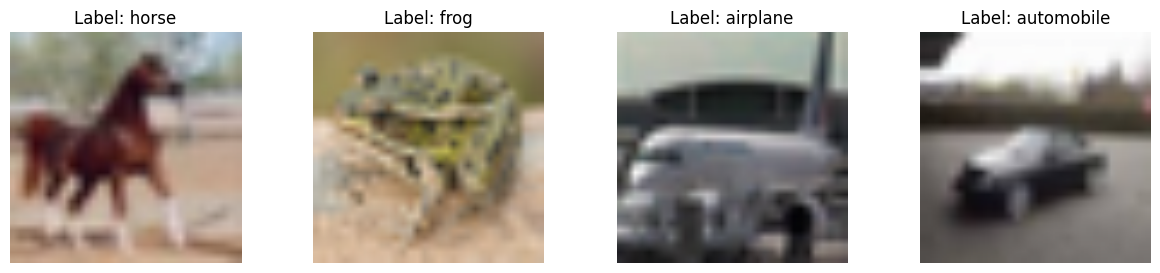

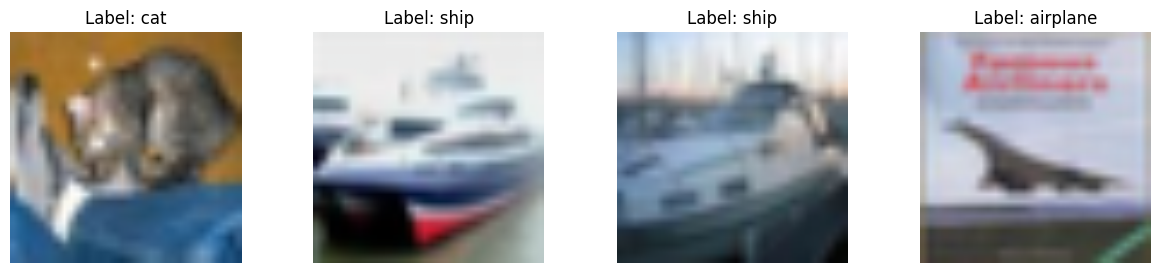

In [4]:
# from torchvision.transforms.functional  import to_pil_image 
# 反归一化转换（需与transform中的参数对应）
inv_normalize = transforms.Normalize(
    mean=[-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010],
    std=[1/0.2023, 1/0.1994, 1/0.2010]
)
 
def show_images(loader, num_images=4):
    # 获取一个batch的数据 
    # images, labels = next(iter(loader))
    for batch_idx, (images, labels) in enumerate(loader):
        if batch_idx == 0:  # 只取第一个batch 
            break 

    # 创建子图 
    fig, axes = plt.subplots(1,  num_images, figsize=(15, 3))
    
    for i in range(num_images):
        # 反归一化+通道顺序调整 
        img = inv_normalize(images[i]).permute(1, 2, 0).numpy()
        img = np.clip(img,  0, 1)  # 处理浮点误差 
        
        # 显示图像及标签 
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {trainset.classes[labels[i]]}") 
        axes[i].axis('off')
    
    plt.show() 
 
show_images(trainloader['train'])
show_images(testloader)

In [5]:
from optimizers import PUGD
import time, copy,timm


In [6]:
model_ft = timm.create_model('mobilenetv3_small_100', pretrained=True, num_classes=Num_class)
original_head = model_ft.classifier   # MobileNetV3的分类头名为classifier 
new_head = nn.Linear(original_head.in_features,  Num_class)

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
          
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in trainloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.first_step()
                        
                        outputs = model(inputs)        
                        loss = criterion(outputs, labels)       
                        loss.backward()
                        optimizer.second_step(zero_grad=True)
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
model_ft = model_ft.to(device)
criterion = torch.nn.CrossEntropyLoss()


base_optimizer = optim.SGD
optimizer = PUGD(model_ft.parameters(),
                 base_optimizer,
                 lr=args.lr,
                 momentum=args.momentum,
                 weight_decay=args.wd,
                 )


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, num_epochs=2) 

Epoch 0/1
----------
train Loss: 5.0181 Acc: 0.1266
valid Loss: 4.3884 Acc: 0.0794

Epoch 1/1
----------
train Loss: 3.7047 Acc: 0.3927
valid Loss: 3.5412 Acc: 0.1268

Training complete in 10m 49s
Best val Acc: 0.126800
